# Example optimisation with stochastic nonlocal modifications and gradient descent

## Imports and prep

In [24]:
# %pip install seaborn

In [25]:
import seaborn as sns

In [1]:
from ship_routing.core import Route, WayPoint
from ship_routing.data import (
    load_currents,
    load_winds,
    load_waves,
)
from ship_routing.algorithms import (
    gradient_descent_across_track_left,
    gradient_descent_along_track,
    gradient_descent_time_shift,
    LargeIncrementError,
    InvalidGradientError,
    ZeroGradientsError,
)

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
import tqdm
from random import choice

In [3]:
np.random.seed(345)
population_size = 200
target_acceptance_fraction = 1/30.0
reproduction_fraction = 0.33
num_generations = 5

## Load and plot currents, winds, waves

In [4]:
currents = load_currents(
    data_file="data/currents/cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m_2021-01_100W-020E_10N-65N.nc"
)
currents["speed"] = ((currents.to_array() ** 2).sum("variable") ** 0.5).where(
    ~currents.uo.isnull()
)

currents

<xarray.Dataset> Size: 10MB
Dimensions:  (lat: 661, lon: 1321, time: 1)
Coordinates:
    depth    float32 4B ...
  * lat      (lat) float32 3kB 10.0 10.08 10.17 10.25 ... 64.75 64.83 64.92 65.0
  * lon      (lon) float32 5kB -100.0 -99.92 -99.83 -99.75 ... 9.833 9.917 10.0
  * time     (time) datetime64[ns] 8B 2021-01-01
Data variables:
    uo       (time, lat, lon) float32 3MB -0.1356 -0.1479 ... 0.07963 0.05846
    vo       (time, lat, lon) float32 3MB -0.01258 -0.02277 ... 0.2739 0.4073
    speed    (time, lat, lon) float32 3MB 0.1362 0.1497 0.163 ... 0.2852 0.4115
Attributes:
    Conventions:  CF-1.8
    area:         Global
    contact:      https://marine.copernicus.eu/contact
    credit:       E.U. Copernicus Marine Service Information (CMEMS)
    institution:  Mercator Ocean International
    licence:      http://marine.copernicus.eu/services-portfolio/service-comm...
    producer:     CMEMS - Global Monitoring and Forecasting Centre
    references:   http://marine.copernicus.eu
    source:       MOI GLO12
    title:        daily mean fields from Global Ocean Physics Analysis and Fo...

In [5]:
winds = load_winds(
    data_file="data/winds/cmems_obs-wind_glo_phy_my_l4_0.125deg_PT1H_2021-01_6hours_0.5deg_100W-020E_10N-65N.nc"
)
winds["speed"] = ((winds.to_array() ** 2).sum("variable") ** 0.5).where(
    ~winds.uw.isnull()
)
winds

<xarray.Dataset> Size: 26MB
Dimensions:  (time: 125, lat: 110, lon: 160)
Coordinates:
  * lat      (lat) float32 440B 10.06 10.56 11.06 11.56 ... 63.56 64.06 64.56
  * lon      (lon) float32 640B -99.94 -99.44 -98.94 ... -21.44 -20.94 -20.44
  * time     (time) datetime64[ns] 1kB 2021-01-01 ... 2021-02-01
Data variables:
    uw       (time, lat, lon) float32 9MB 1.77 2.06 1.19 ... -1.06 -0.82 -0.7
    vw       (time, lat, lon) float32 9MB -3.44 -3.66 -4.05 ... 0.15 0.1 -0.26
    speed    (time, lat, lon) float32 9MB 3.869 4.2 4.221 ... 0.8261 0.7467
Attributes: (12/26)
    Conventions:                CF-1.6, ACDD-1.3
    date_created:               2024-03-25T23:58:22
    date_modified:              2024-03-25T23:58:22
    geospatial_lat_max:         89.9375
    geospatial_lat_min:         -89.9375
    geospatial_lat_resolution:  0.125
    ...                         ...
    project:                    Copernicus Marine Service Wind Thematic Assem...
    references:                 Copernicus Marine Service Product User Manual...
    summary:                    Global ocean 10-m stress-equivalent wind and ...
    time_coverage_end:          2023-12-21T23:00:00
    time_coverage_start:        2023-12-21T23:00:00
    title:                       Global Ocean - Wind and Stress - Hourly - Re...

In [6]:
waves = load_waves(
    data_file="data/waves/cmems_mod_glo_wav_my_0.2deg_PT3H-i_VHM0_2021-01_1d-max_100W-020E_10N-65N.nc"
)

waves

<xarray.Dataset> Size: 14MB
Dimensions:  (lat: 276, lon: 401, time: 32)
Coordinates:
  * lat      (lat) float32 1kB 10.0 10.2 10.4 10.6 10.8 ... 64.4 64.6 64.8 65.0
  * lon      (lon) float32 2kB -100.0 -99.8 -99.6 -99.4 ... -20.4 -20.2 -20.0
  * time     (time) datetime64[ns] 256B 2001-01-01T12:00:00 ... 2001-02-01T12...
Data variables:
    wh       (time, lat, lon) float32 14MB ...

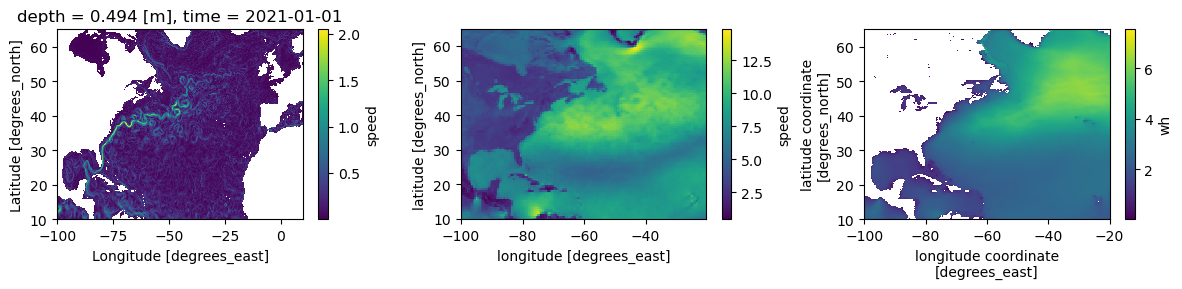

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

currents.speed.plot(ax=ax[0])
winds.speed.mean("time").plot(ax=ax[1])
waves.wh.mean("time").plot(ax=ax[2])

fig.tight_layout();

## Define a route and have a look

In [8]:
route_0 = Route(
    way_points=(
        WayPoint(lon=-80.5, lat=30, time=np.datetime64("2021-01-01")),
        WayPoint(lon=-10, lat=50, time=np.datetime64("2021-01-11")),
    )
)
# refine to 12 hourly way points
refine_to = np.mean([l.speed_ms for l in route_0.legs]) * 12 * 3600.0
route_0 = route_0.refine(distance_meters=refine_to)
route_0

Route(way_points=(WayPoint(lon=-80.5, lat=30, time=numpy.datetime64('2021-01-01')), WayPoint(lon=-78.098519636058, lat=31.855837618895183, time=numpy.datetime64('2021-01-01T11:59:59.999')), WayPoint(lon=-75.60015737467967, lat=33.6639713948614, time=numpy.datetime64('2021-01-01T23:59:59.999')), WayPoint(lon=-72.99663283537555, lat=35.41896272444271, time=numpy.datetime64('2021-01-02T11:59:59.999')), WayPoint(lon=-70.27967718012803, lat=37.11487954484631, time=numpy.datetime64('2021-01-02T23:59:59.999')), WayPoint(lon=-67.44123126301778, lat=38.74527014071479, time=numpy.datetime64('2021-01-03T11:59:59.999')), WayPoint(lon=-64.47371094073974, lat=40.303149089749574, time=numpy.datetime64('2021-01-03T23:59:59.999')), WayPoint(lon=-61.37034871434607, lat=41.78100113563067, time=numpy.datetime64('2021-01-04T11:59:59.999')), WayPoint(lon=-58.12561687605418, lat=43.170809951530096, time=numpy.datetime64('2021-01-04T23:59:59.999')), WayPoint(lon=-54.73572989755354, lat=44.46411963593293, time

In [9]:
print("speed (m/s)", np.mean([l.speed_ms for l in route_0.legs]))

speed (m/s) 7.134894006504659


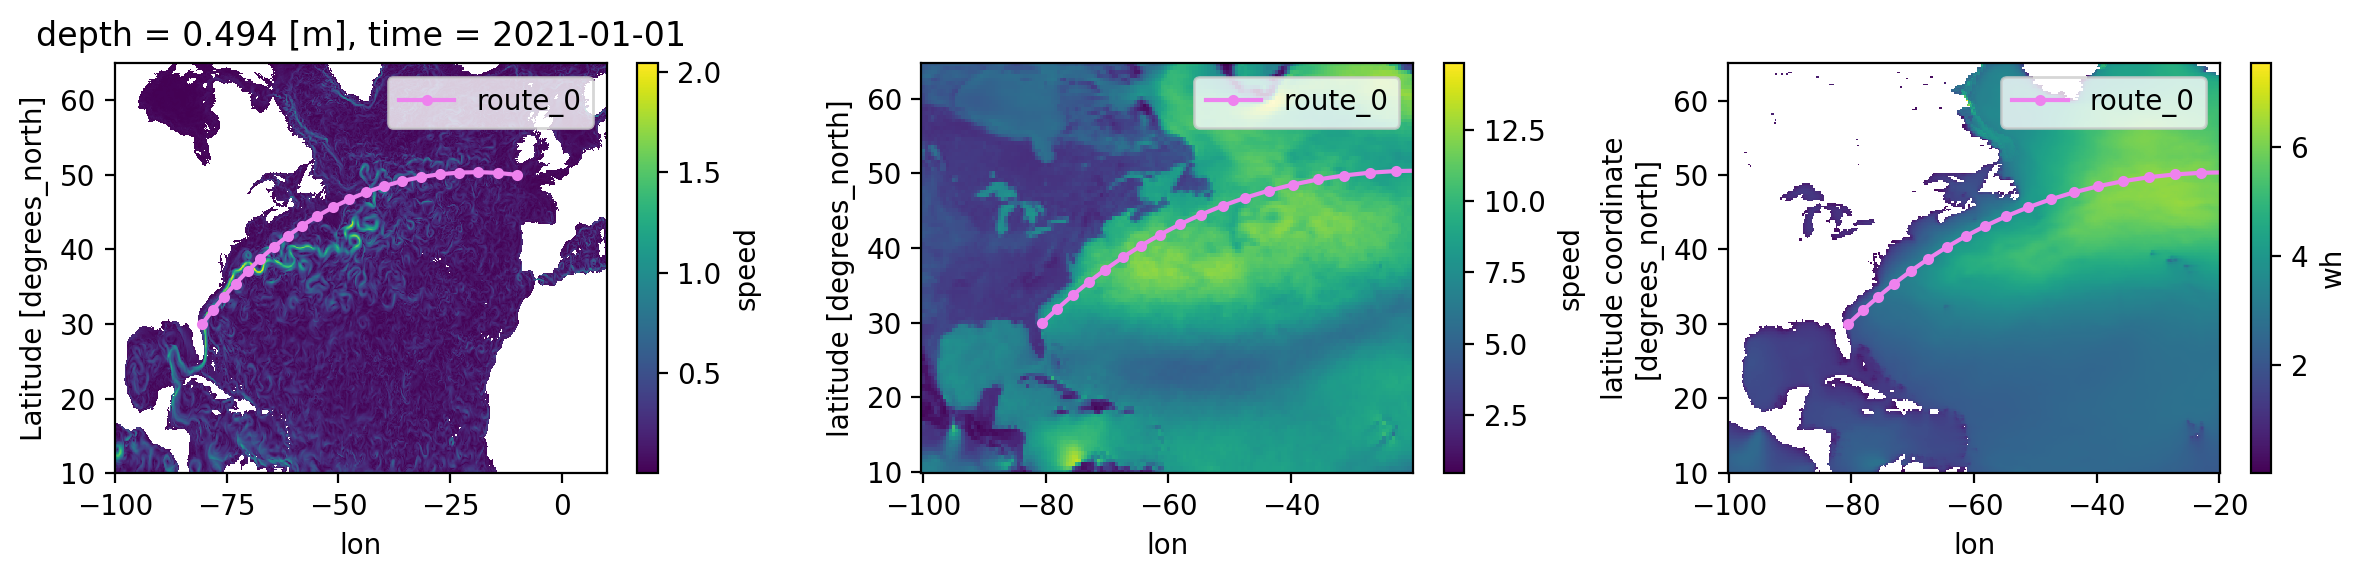

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

fig.set_dpi(200)

currents.speed.plot(ax=ax[0])
winds.speed.mean("time").plot(ax=ax[1])
waves.wh.mean("time").plot(ax=ax[2])

for _ax in ax.flatten():
    route_0.data_frame.plot.line(
        x="lon", y="lat", marker=".", ax=_ax, color="violet", label="route_0"
    )

fig.tight_layout();

## Replicate route

In [11]:
# note that as Route is immutable, this is safe...
routes = [route_0 for n in range(population_size)]
cost_0 = route_0.cost_through(
    current_data_set=currents,
    wave_data_set=waves,
    wind_data_set=winds,
)
costs = [cost_0 for n in range(population_size)]

## Stochastic Optimisation

In [12]:
max_width = 0.99 * route_0.length_meters
max_dist_mod = 0.99 * max_width

In [20]:
# cost_records = [tuple(costs)]
for n in range(num_generations):
    
    accepted = 0
    for (npop, (_route, _cost)) in tqdm.tqdm(enumerate(zip(routes, costs))):
        _route = _route.move_waypoints_left_nonlocal(
            center_distance_meters=np.random.uniform(
                max_width / 2.0, _route.length_meters - max_width / 2.0
            ),
            width_meters=max_width,
            max_move_meters=np.random.uniform(-max_dist_mod, max_dist_mod),
        )
        _cost_next = _route.cost_through(
            current_data_set=currents,
            wave_data_set=waves,
            wind_data_set=winds,
        )
        if not np.isnan(_cost_next) and _cost_next < _cost:
            routes[npop] = _route
            costs[npop] = _cost_next
            accepted += 1
    print(accepted)
    if accepted < population_size * target_acceptance_fraction:
        max_width /= 2 ** 0.5
        max_dist_mod /= 2 ** 0.5
    else:
        _rc = [(r, c) for r, c in zip(routes, costs) if c < pd.Series(costs).quantile(reproduction_fraction)]
        rc = [choice(_rc) for n in range(population_size)]
        routes, costs = zip(*rc)
        routes = list(routes)
        costs = list(costs)
    cost_records.append(tuple(costs))

200it [00:55,  3.60it/s]


8


200it [00:55,  3.57it/s]


8


200it [00:56,  3.56it/s]


2


200it [00:56,  3.54it/s]


4


200it [00:56,  3.57it/s]

11


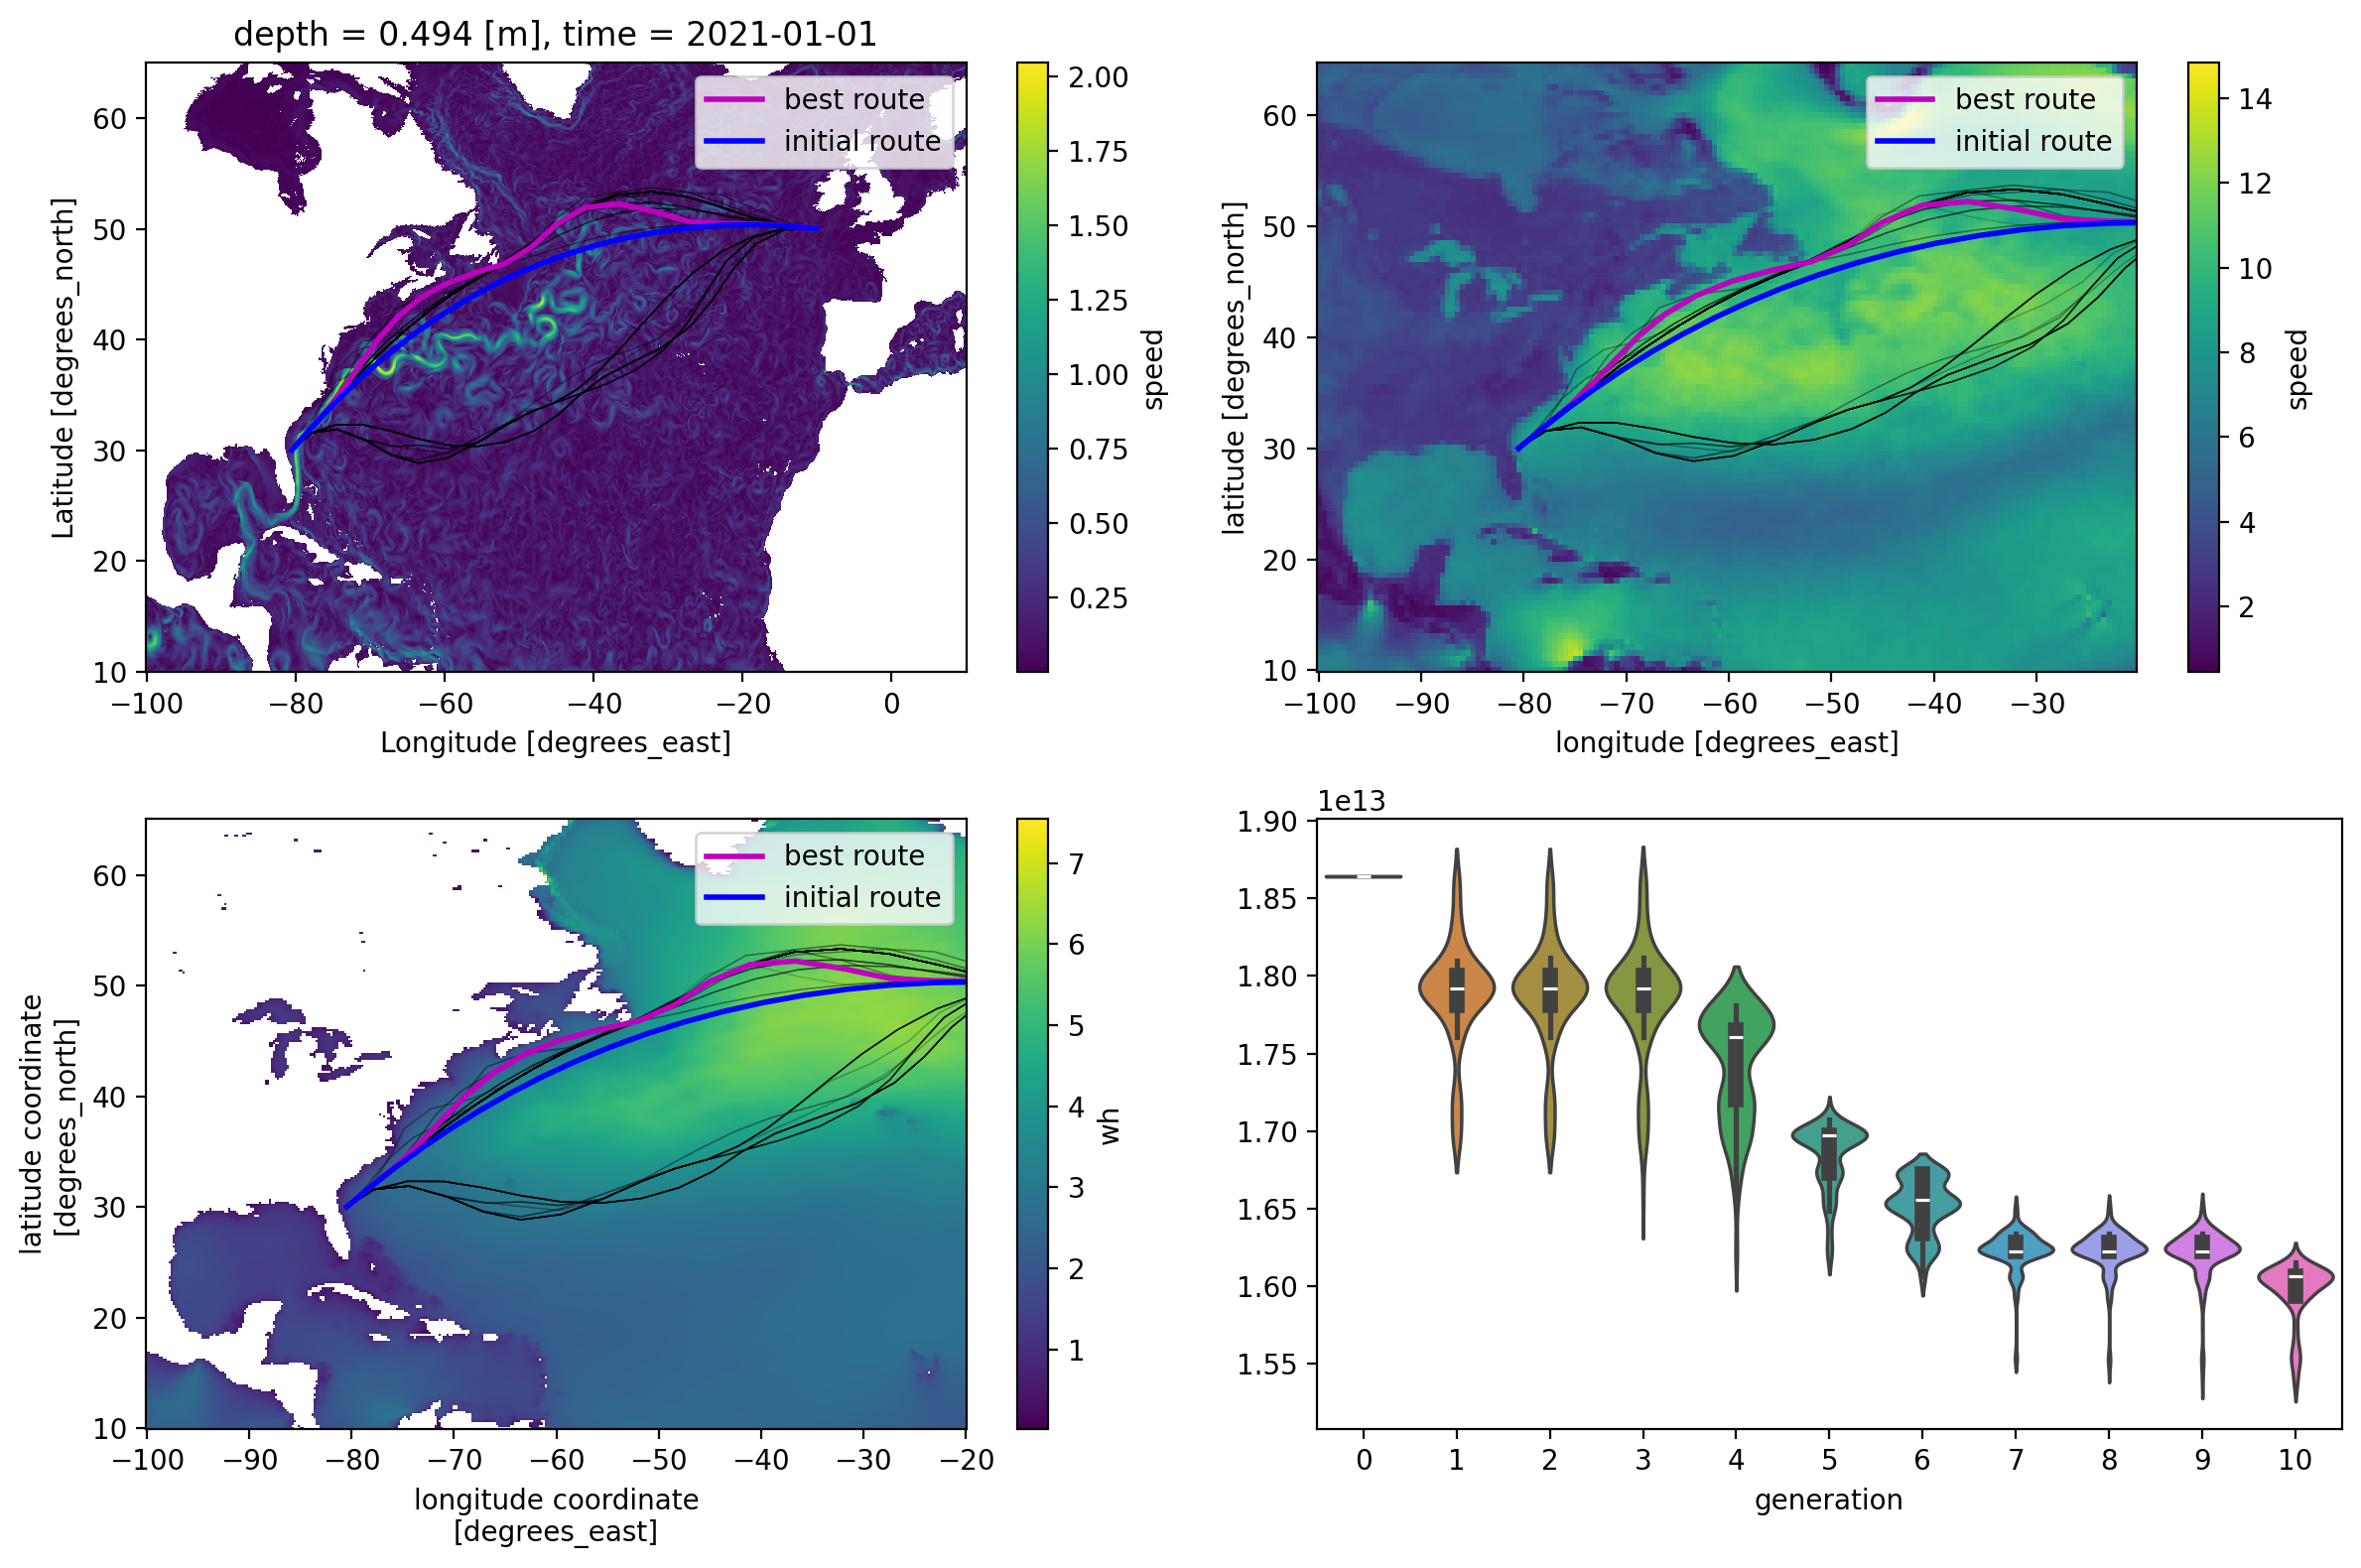

In [47]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax = ax.flatten()

fig.set_dpi(200)

currents.speed.plot(ax=ax[0])
winds.speed.mean("time").plot(ax=ax[1])
waves.wh.mean("time").plot(ax=ax[2])

for _ax in ax[:-1]:
    # route_0.data_frame.plot.line(
    #     x="lon", y="lat", marker=".", ax=_ax, color="violet", label="route_0"
    # )
    for r in routes:
        _ax.plot(*r.line_string.xy, '-k', alpha=0.1, linewidth=0.5)
    _ax.plot(*routes[pd.Series(costs).argmin()].line_string.xy, '-m', label="best route", linewidth=2.0)
    _ax.plot(*route_0.line_string.xy, '-b', label="initial route", linewidth=2.0)
    _ax.legend()

sns.violinplot(pd.DataFrame.from_records(cost_records).T, ax=ax[-1])
ax[-1].set_xlabel("generation")

fig.tight_layout();